In [97]:
from process_cube.dat import read_dat_file, Header
import numpy as np
header = Header.read_header("self_test_rad.hdr")
img = read_dat_file("self_test_rad.img", header).astype(np.float64)
fimg = img.reshape(-1, header.bands)

In [98]:
import numba
@numba.njit()
def update_mu(lambda_arr, mu, pi, i):
    for j in range(i):
        if (lambda_arr[j] >= mu[j]):
            mu[pi[j]] = min(mu[pi[j]], lambda_arr[j])
            lambda_arr[j] = mu[j]
            pi[j] = i
        else:
            mu[pi[j]] = min(mu[pi[j]], mu[j])
    
    for j in range(i):
        if lambda_arr[j] >= lambda_arr[pi[j]]:
            pi[j] = i

@numba.njit(parallel=True)
def euclidean(X,Y):
    norms = np.empty(Y.shape[0], dtype=Y.dtype)
    for i in numba.prange(Y.shape[0]):
        square_sum = 0
        for j in range(Y.shape[1]):
            diff = Y[i][j] - X[j]
            square_sum += diff*diff
        norms[i] = np.sqrt(square_sum)
    return norms

a = np.random.rand(100)
euclidean(a,a.reshape(1,-1))

array([0.])

In [99]:
# %%prun
from scipy.cluster.hierarchy import linkage
from tqdm.notebook import tqdm


def find_parent(forest,index):
    if forest[index] == index:
        return index
    forest[index] = find_parent(forest, forest[index])
    return forest[index]



def SLINK(vectors, dist_func):
    pi = np.zeros(vectors.shape[0], dtype=np.int32)
    lambda_arr = np.ones(len(vectors),dtype=np.float64) * np.inf
    mu = np.ones(len(vectors),dtype=np.float64) * np.inf
    
    for i in tqdm(range(vectors.shape[0])):
        # vectorize: np.linalg.norm(vectors[i] - vectors[:i], axis=-1)
#         for j in range(i):
#             mu[j] = dist_func(vectors[i], vectors[j])
        mu[:i] = dist_func(vectors[i], vectors[:i])
        
        # This should be vectorized but I'm not 100% how
        update_mu(lambda_arr,mu,pi,i)
    
    forest = np.arange(vectors.shape[0]*2)
    linkage_matrix = np.ones((vectors.shape[0]-1, 4))
    order = np.argsort(lambda_arr)
    for i in tqdm(range(vectors.shape[0] -1)):
        current = order[i]
        current_lambda = lambda_arr[current]
        current_pi = pi[current]
        
        parent_index = find_parent(forest, current)
        parent_dim = 1 if parent_index < vectors.shape[0] else linkage_matrix[parent_index - vectors.shape[0]][3]
        
        pair_parent_index = find_parent(forest, current_pi)
        pair_parent_dim = 1 if pair_parent_index < vectors.shape[0] else linkage_matrix[pair_parent_index - vectors.shape[0]][3]
        
        linkage_matrix[i] = (
            min(parent_index,pair_parent_index), 
            max(pair_parent_index,parent_index), 
            current_lambda, 
            parent_dim + pair_parent_dim
        )
        joined = i + vectors.shape[0]
        forest[min(parent_index,joined)] = max(joined,parent_index)
        forest[min(pair_parent_index,joined)] = max(joined, pair_parent_index)

    return linkage_matrix,pi
N = len(fimg)
vectors = fimg[:N]
# vectors = np.random.normal(0,1,size=(N,3))
# print("scipy")
# scipy = linkage(vectors, 'single')
# print("SLINK")
mine, pi = SLINK(vectors, euclidean)
# print(np.all(scipy[:,[0,1,3]] == mine[:,[0,1,3]]))
            

  0%|          | 0/224000 [00:00<?, ?it/s]

In [28]:
# from dash import Dash, html
# import dash_cytoscape as cyto

# def create_node(i):
#     if (i == 447998):
#         print(i)
#     return {"data": {"id": i, "label": i}}

# def create_edge(i,j):
#     return {"data": {"source":i, "target": j}}

# cyto.load_extra_layouts()
# app = Dash(__name__)

# app.layout = html.Div([
#     html.P("Dash Cytoscape:"),
#     cyto.Cytoscape(
#         id='cytoscape',
#         elements=[
#             *(create_node(i) for i in range(vectors.shape[0]*2 - 1)),
#             *(create_edge(v,vectors.shape[0]+i) for i,v in enumerate(mine[:,0] )),
#             *(create_edge(v,vectors.shape[0]+i) for i,v in enumerate(mine[:,1] )),
#         ],
# #         layout={'name': 'dagre',"rankDir": 'LR',},
#         style={'width': '100%', 'height': '1000px', 'border': '3px solid black'}
#     )
# ])


# app.run_server(debug=True)

In [1]:
import networkx as nx
import numpy as np
from process_cube.dat import read_dat_file, Header
import numpy as np
header = Header.read_header("self_test_rad.hdr")
img = read_dat_file("self_test_rad.img", header).astype(np.float64)
fimg = img.reshape(-1, header.bands)
mine = np.fromfile("hierarchy").reshape(-1,4)
vectors = fimg

graph = nx.DiGraph()
nodes = [0]*(vectors.shape[0]*2-1)
for i in range(vectors.shape[0]*2 - 1):
    nodes[i] = {
        "dist": 0 if i < vectors.shape[0] else mine[i-vectors.shape[0],2],
        "dim": 1 if i < vectors.shape[0] else mine[i-vectors.shape[0],3],
        "parent": i,
        "value": i
    }
    graph.add_node(
        i, 
        dist=0 if i < vectors.shape[0] else mine[i-vectors.shape[0],2],
        dim=1 if i < vectors.shape[0] else mine[i-vectors.shape[0],3],
        parent=i,
        value=i
    )
for i,v in enumerate(mine[:,0] ):
    parent= vectors.shape[0]+i
    graph.add_edge(parent,v)
    nx.set_node_attributes(graph,values={v: parent}, name="parent")
    nodes[int(v)]["parent"] = parent
for i,v in enumerate(mine[:,1] ):
    parent= vectors.shape[0]+i
    graph.add_edge(parent,v)
    nx.set_node_attributes(graph,values={v: parent}, name="parent")
    nodes[int(v)]["parent"] = parent
    


In [2]:
from ipywidgets import Label
from tqdm.notebook import tqdm
root_id = vectors.shape[0]*2-2
iter_bfs = nx.bfs_successors(graph,root_id)
paths = {}
i = 0
arg_maximal = {root_id: 0}
maximal = [graph.nodes[root_id]]

def key(node):
    return node["dim"]

def sort_dim(nodes):
    return nodes.sort(key=key, reverse=True)

def sort_maximal(maximal, arg_maximal):
    sort_dim(maximal)
    for i,node in enumerate(maximal):
        arg_maximal[node["value"]] = i

def remove_maximal(maximal, arg_maximal, index):
    pos = arg_maximal.pop(index)
    del maximal[pos]
    
N = 4
for parent, successors in tqdm(iter_bfs):
#     path = paths.get(node,tuple())
#     path = (*path, node)
#     for succesor in successors:
#         paths[succesor] = path
    nodes = [graph.nodes[succesor] for succesor in successors]
    if len(maximal) < N:
        remove_maximal(maximal, arg_maximal, parent)
    else:
        sort_dim(nodes)
        nodes = [node for node in nodes if node["dim"] > maximal[-1]["dim"]]
        if len(nodes) < 2:
            continue
        max_parent = parent
        while max_parent not in arg_maximal:
            max_parent = graph.nodes[max_parent]["parent"]
        remove_maximal(maximal, arg_maximal, max_parent)
    maximal+=nodes
    sort_maximal(maximal, arg_maximal)
    for node in maximal[N:]:
        del arg_maximal[node["value"]]
    maximal = maximal[:N]

maximal

0it [00:00, ?it/s]

[{'dist': 280.27664904518895,
  'dim': 107987.0,
  'parent': 368464,
  'value': 368459},
 {'dist': 280.28021692584724,
  'dim': 14093.0,
  'parent': 368464,
  'value': 368461},
 {'dist': 415.45156155681974,
  'dim': 2072.0,
  'parent': 418939,
  'value': 418832},
 {'dist': 313.4166555880526, 'dim': 1261.0, 'parent': 385490, 'value': 385342}]

In [3]:
paths = [nx.shortest_path(graph, vectors.shape[0]*2-2, node["value"]) for node in maximal]
groups = [tuple(range(len(paths)))]
path_split = {groups[0]: (0,0)}
lowest_non_common = {}

i = 0
while len(groups) > 0:
    i+=1
    new_groups = []
    for group in groups:
        
        group_paths = [paths[path_ind] for path_ind in group]
        split = {}
        for path_ind in group:
            path = paths[path_ind]
            v = path[i]
            out = split.get(v, [])
            split[v] = out+[path_ind]
        path_split[group] = (path_split[group][0],i-1)
        for group in split.values():
            group = tuple(group)
            if group not in path_split:
                path_split[group] = (i,i)
            if len(group) > 1:
                new_groups.append(group)
            else:
                lowest_non_common[group[0]] = paths[group[0]][i-1]
    groups = new_groups
    
clusters_roots = {group: paths[group[0]][split[0]] for group, split in path_split.items()}
clusters_roots

{(0, 1, 2, 3): 447998,
 (0, 1, 3): 418936,
 (2,): 418832,
 (0, 1): 385487,
 (3,): 385342,
 (0,): 368459,
 (1,): 368461}

In [4]:
descendants = {group: nx.descendants(graph, cluster_root) for group,cluster_root in reversed(clusters_roots.items())}

total = set()
clusters = {}
leaves = set(range(vectors.shape[0]))
for group, cluster in tqdm(descendants.items()):
    cluster = leaves.intersection(cluster)
    clusters[group] = (cluster - total)
    total = total.union(cluster)
other = leaves - total
[len(cluster) for cluster in clusters.values()]

  0%|          | 0/7 [00:00<?, ?it/s]

[14093, 107987, 1261, 19414, 2072, 40972, 38201]

In [5]:
from matplotlib.cm import get_cmap
colors = get_cmap("Set1").colors
def cycle_colors(i, bad_i=-1):
    if i == bad_i:
        return get_cmap("Set1").get_bad()[:3]
    return colors[i%len(colors)][:3]

In [6]:
%matplotlib widget
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from tqdm.notebook import tqdm
rgb = img[:,:,[1,5,11]]

rgb = rgb - rgb.min()
rgb = rgb/rgb.max()
plt.figure()
plt.imshow(rgb)

cluster_image = np.zeros_like(rgb)
for k, cluster in enumerate(clusters.values()):
    for n in cluster:
        n = int(n)
        i = n // img.shape[1]
        j = n % img.shape[1]
        cluster_image[i,j] = cycle_colors(k)
for n in other:
    n = int(n)
    i = n // img.shape[1]
    j = n % img.shape[1]
    cluster_image[i,j] = cycle_colors(-1,bad_i=-1)
fig, (ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [10, 1]})
ax1.imshow(cluster_image,extent=(0, cluster_image.shape[1], cluster_image.shape[0], 0))
ax2.imshow(np.array([[cycle_colors(k) for k,_ in enumerate(clusters)]]).swapaxes(0,1), extent=(0,3,0,len(clusters)))
for k,cluster_name in enumerate(clusters_roots):
    ax2.text(0.5,k+0.5,str(clusters_roots[cluster_name]))
    


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [119]:
import json
with open("clusters.json",'w') as f:
    json.dump({i: {"name": name, "cluster": [(int(index//img.shape[1]), int(index % img.shape[1])) for index in cluster]} for i,(name, cluster) in enumerate(clusters.items())},f)

[[ 0.  1.  1.  2.]
 [ 2. 12.  1.  3.]
 [ 3.  4.  1.  2.]
 [ 5. 14.  1.  3.]
 [ 7.  8.  1.  2.]
 [ 9. 16.  1.  3.]
 [10. 11.  1.  2.]
 [13. 15.  2.  6.]
 [ 6. 19.  3.  7.]
 [17. 20.  4. 10.]
 [18. 21.  5. 12.]]
18
16
17
12
13
14
15
19
20
21
22


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [72.5, 72.5, 102.5, 102.5],
  [55.0, 55.0, 87.5, 87.5],
  [32.5, 32.5, 71.25, 71.25],
  [10.0, 10.0, 51.875, 51.875]],
 'dcoord': [[0.0, 1.0, 1.0, 0.0],
  [0.0, 1.0, 1.0, 0.0],
  [0.0, 1.0, 1.0, 1.0],
  [0.0, 1.0, 1.0, 0.0],
  [0.0, 1.0, 1.0, 1.0],
  [0.0, 1.0, 1.0, 0.0],
  [0.0, 1.0, 1.0, 1.0],
  [1.0, 2.0, 2.0, 1.0],
  [0.0, 3.0, 3.0, 2.0],
  [1.0, 4.0, 4.0, 3.0],
  [1.0, 5.0, 5.0, 4.0]],
 'ivl': ['10', '11', '9', '7', '8', '6', '2', '0', '1', '5', '3', '4'],
 'leaves': [10, 11, 9, 7, 8, 6, 2, 0, 1, 5, 3, 4],
 'color_list': ['purple',
  'orange',
  'orange',
  'r',
  'r',
  'g',
  'g',
  'k',
  'brown',
  'k',
  'k'],
 'leaves_color_list': ['purple',
  'purple',
  'orange',
  'orange',
  'orange',
  'brown',
  'r',
  'r',
  'r',
  'g',
  'g',
  'g']}

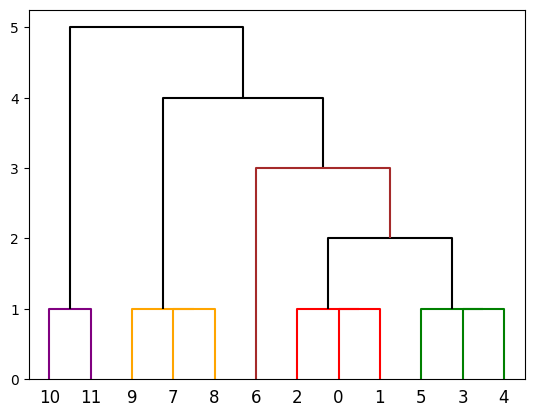

In [96]:
from scipy.cluster.hierarchy import linkage, dendrogram
colors = {
    12: "r",
    13: "r",
    14: "g",
    15: 'g',
    16: "orange",
    17: "orange",
    18: "purple",
    20: "brown",
}
def test(k):
    print(k)
    return colors.get(k, "k")
distances = [1,1,1,2,1,1,3,4,1,1,5,1]
out = linkage([[i] for i in np.cumsum(distances)], method="single")
print(out)
dendrogram(out, color_threshold=-1, show_leaf_counts=True, get_leaves=True, link_color_func=test, orientation='top')

In [184]:
import numpy as np
v =np.array([1,1,0,0,0,0,0,0])
v2 = np.array([1,-1,1,0,0,0,0,0])
A = np.hstack([np.roll(v.reshape(-1,1),i) for i in range(v.shape[0])])
A2 = np.hstack([np.roll(v2.reshape(-1,1),i) for i in range(v2.shape[0])])
A = np.hstack([A,A2])
U,Sigma,Vh = np.linalg.svd(A, full_matrices=False)
A



array([[ 1,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1, -1],
       [ 1,  1,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,  0,  0,  1],
       [ 0,  1,  1,  0,  0,  0,  0,  0,  1, -1,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  1,  0,  0,  0,  0,  0,  1, -1,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1, -1,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1, -1,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1, -1,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1, -1,  1]])

In [200]:
A.shape, U.shape, Sigma.shape, Vh.shape

((8, 16), (8, 8), (8,), (8, 16))

In [202]:
list(A.T.conj() @ v), Vh.T.conj() @ ( Sigma * (U.T.conj() @ v) ), ( Sigma * (U.T.conj() @ v) )

([2, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
 array([ 2.00000000e+00,  1.00000000e+00,  4.99600361e-16,  3.33066907e-16,
        -2.77555756e-16, -4.44089210e-16,  7.21644966e-16,  1.00000000e+00,
        -5.82867088e-16,  1.00000000e+00, -5.27355937e-16,  0.00000000e+00,
         5.55111512e-17,  7.49400542e-16,  1.00000000e+00,  1.38777878e-15]),
 array([ 2.49800181e-15,  8.95419843e-01,  3.70895043e-01, -1.58113883e+00,
         6.69494813e-01,  1.61630346e+00,  8.66025404e-01, -8.66025404e-01]))

In [201]:
Sigma

array([3.        , 2.53262977, 2.53262977, 2.23606798, 1.89361729,
       1.89361729, 1.73205081, 1.73205081])

In [203]:
U, Sigma, Vh


(array([[-3.53553391e-01, -2.96451690e-17,  5.00000000e-01,
         -3.53553391e-01, -2.06163240e-17,  5.00000000e-01,
          5.00000000e-01,  5.98638014e-17],
        [ 3.53553391e-01,  3.53553391e-01, -3.53553391e-01,
         -3.53553391e-01,  3.53553391e-01,  3.53553391e-01,
         -6.93889390e-17, -5.00000000e-01],
        [-3.53553391e-01, -5.00000000e-01,  9.15933995e-16,
         -3.53553391e-01,  5.00000000e-01,  3.60822483e-16,
         -5.00000000e-01, -1.63181460e-15],
        [ 3.53553391e-01,  3.53553391e-01,  3.53553391e-01,
         -3.53553391e-01,  3.53553391e-01, -3.53553391e-01,
          6.10622664e-16,  5.00000000e-01],
        [-3.53553391e-01, -2.98372438e-15, -5.00000000e-01,
         -3.53553391e-01,  2.98372438e-16, -5.00000000e-01,
          5.00000000e-01,  2.63677968e-16],
        [ 3.53553391e-01, -3.53553391e-01,  3.53553391e-01,
         -3.53553391e-01, -3.53553391e-01, -3.53553391e-01,
          5.13478149e-16, -5.00000000e-01],
        [-3.5355

In [204]:
np.unique(np.around(U.T,3))

array([-0.5  , -0.354, -0.   ,  0.354,  0.5  ])

In [211]:
np.unique(np.around(Vh.T,13))

array([-0.47662189, -0.45075285, -0.35355339, -0.33702257, -0.31622777,
       -0.28867513, -0.18670794, -0.15811388, -0.13959932, -0.10937098,
       -0.07733696, -0.05782393,  0.        ,  0.05782393,  0.07733696,
        0.10937098,  0.13959932,  0.18670794,  0.28867513,  0.33702257,
        0.35355339,  0.45075285,  0.47662189])